In [2]:
import numpy as np
import matplotlib.pyplot as plt
import descent
from ipywidgets import interact
from functools import partial
%matplotlib inline

In [4]:
import sklearn
from sklearn.datasets import make_regression

# Sparse linear regression

Again, we first generate a toy problem instance:

In [5]:
A, y, x = make_regression(n_samples=20, n_features=50, n_informative=5, coef=True)

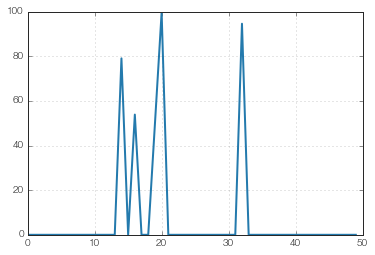

In [6]:
plt.plot(x)

## Least squares

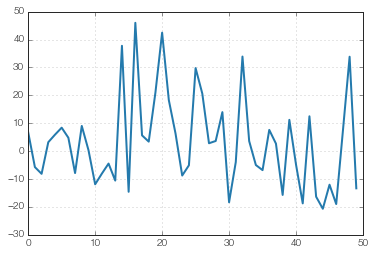

In [7]:
x_lsq = np.linalg.lstsq(A, y)[0]
plt.plot(x_lsq)

## Subgradient descent

In [43]:
# squared error objective
def f_df(x):
    err = A.dot(x) - y
    objective = 0.5 * np.linalg.norm(err) ** 2
    gradient = A.T.dot(err)
    return objective, gradient

# squared error + sparsity penalty
def f_df_sparse(x, penalty=0.5):
    # squared error
    obj, grad = f_df(x)
    
    # tack on the sparsity penalty
    obj_sparse = obj + penalty * np.linalg.norm(x, 1)
    grad_sparse = grad + penalty * np.sign(x)
    
    return obj_sparse, grad_sparse

In [44]:
opt_subg = descent.sgd(f_df_sparse, x_lsq, learning_rate=5e-3)
opt_subg.display.every = 5000
opt_subg.run(5e4)

+----------------+-----------------+----------------+
|Iteration       | Objective       | Runtime        |
+----------------+-----------------+----------------+
|              0 |          321.22 |             0 s|
|           5000 |          263.35 |      115.871 μs|
|          10000 |           241.5 |       113.01 μs|
|          15000 |          229.41 |      123.978 μs|
|          20000 |          221.73 |      117.064 μs|
|          25000 |          214.63 |      110.149 μs|
|          30000 |          207.96 |      134.945 μs|
|          35000 |           201.7 |      110.865 μs|
|          40000 |          195.94 |      109.911 μs|
|          45000 |          190.57 |      109.911 μs|
+----------------+-----------------+----------------+
➛ Final objective: 188.35337631751085
➛ Total runtime: 6.02361 s
➛ All done!



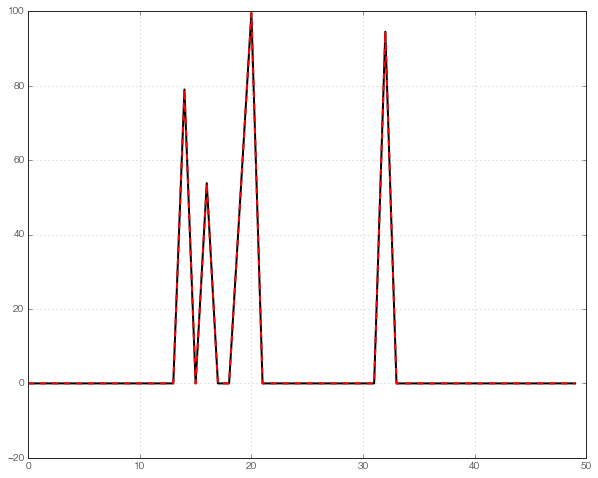

In [48]:
plt.figure(figsize=(10,8))
plt.plot(opt_subg.theta, 'k-')
plt.plot(x, 'r--')

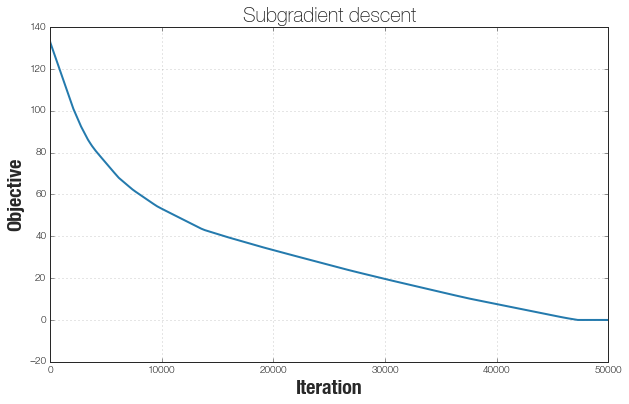

In [52]:
plt.figure(figsize=(10,6))
plt.plot(opt_subg.storage.get('obj') - f_df_subg(x)[0])
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective', fontsize=20)
plt.title('Subgradient descent', fontsize=20)

## Proximal gradient descent

In [75]:
opt_pgd = descent.ProximalGradientDescent(f_df, x_lsq, descent.sparse(10.), learning_rate=1e-3)
opt_pgd.display.every = 5000
db = list();
opt_pgd.callbacks.append(lambda d: db.append(f_df_sparse(d.params)[0]))
opt_pgd.run(5e4)

+----------------+-----------------+----------------+
|Iteration       | Objective       | Runtime        |
+----------------+-----------------+----------------+
|              0 |        0.092284 |             0 s|
|           5000 |          30.358 |      138.998 μs|
|          10000 |          27.013 |      138.998 μs|
|          15000 |          10.768 |      138.044 μs|
|          20000 |          10.768 |      139.952 μs|
|          25000 |          10.768 |      138.998 μs|
|          30000 |          10.768 |      139.952 μs|
|          35000 |          10.768 |      138.044 μs|
|          40000 |          10.768 |       140.19 μs|
|          45000 |          10.768 |      161.886 μs|
+----------------+-----------------+----------------+
➛ Final objective: 10.768379934598592
➛ Total runtime: 7.3296 s
➛ All done!



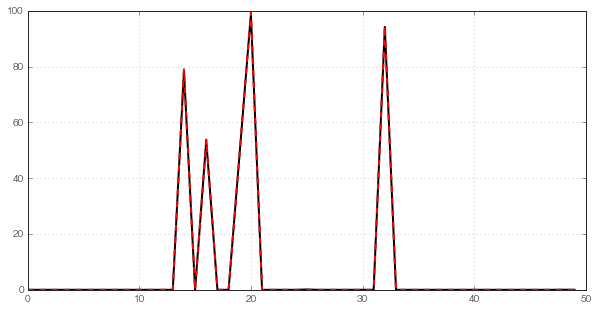

In [76]:
plt.figure(figsize=(10,5))
plt.plot(opt_pgd.theta, 'k-')
plt.plot(x, 'r--')

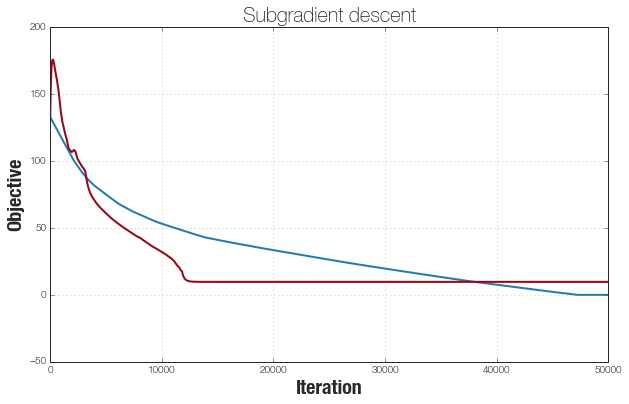

In [77]:
plt.figure(figsize=(10,6))
plt.plot(opt_subg.storage.get('obj') - f_df_subg(x)[0])
plt.plot(np.array(db) - f_df_subg(x)[0])
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective', fontsize=20)
plt.title('Subgradient descent', fontsize=20)

## ADMM

In [78]:
opt_admm = descent.admm(x_lsq, tau=(1., 1., 1.))
opt_admm.add('linsys', A, y)
opt_admm.add('sparse', 0.5)
opt_admm.display.every = 100
opt_admm.run(1000)

+----------------+-----------------+----------------+
|Iteration       | Objective       | Runtime        |
+----------------+-----------------+----------------+
|              0 |          686.75 |             0 s|
|            100 |          483.18 |      1.23501 ms|
|            200 |          443.18 |      442.028 μs|
|            300 |          415.65 |      430.107 μs|
|            400 |          391.77 |      407.934 μs|
|            500 |             377 |      391.006 μs|
|            600 |          376.65 |      365.973 μs|
|            700 |          376.64 |      372.887 μs|
|            800 |          376.64 |      365.019 μs|
|            900 |          376.63 |      477.076 μs|
+----------------+-----------------+----------------+
➛ Final objective: 376.6332391633906
➛ Total runtime: 508.041 ms
➛ All done!



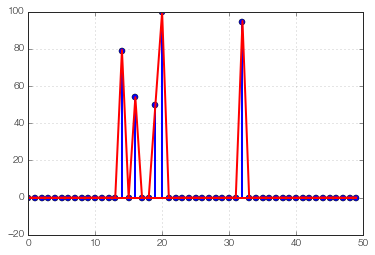

In [20]:
@interact(penalty=(0., 5., 0.5), maxiter=(50, 500, 50))
def solve_sparsereg(penalty=1., maxiter=500):
    opt_admm = descent.admm(x_lsq, tau=(2., 1.5, 1.5))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.run(maxiter)
    plt.stem(x)
    plt.plot(opt_admm.theta, 'r-')

In [42]:
def compare_algs(penalty=1., maxiter=500):
    
    
    # ADMM
    opt_admm = descent.admm(x_lsq, tau=(2., 1.5, 1.5))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.obj = lambda theta: f_df_subg(theta, penalty=penalty)[0]
    opt_admm.run(maxiter=maxiter)
    
    # Subgradient descent
    f_df = partial(f_df_subg, penalty=penalty)
    opt_subg = descent.sgd(f_df, x_lsq, learning_rate=1e-2)
    opt_subg.display = None
    opt_subg.run(maxiter=maxiter)
    
    return opt_admm, opt_subg

In [24]:
admm, subg = compare_algs(penalty=2., maxiter=5000)

In [41]:
descent.apg?

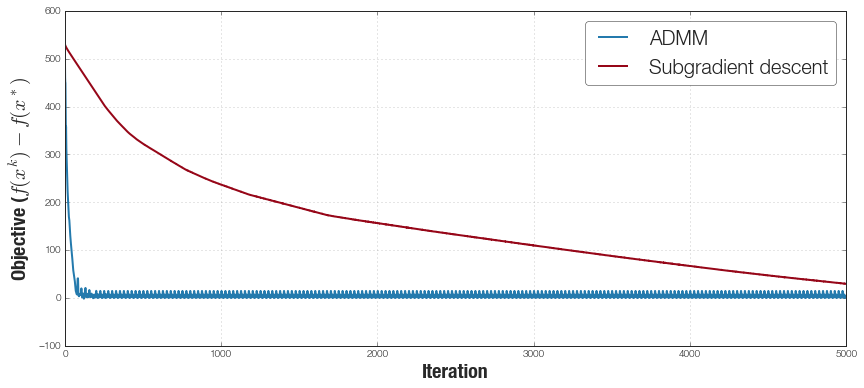

In [37]:
fstar = f_df_subg(x, penalty=2.)[0]
plt.figure(figsize=(14,6))
plt.plot(admm.storage.get('obj')-fstar)
plt.plot(subg.storage.get('obj')-fstar)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective ($f(x^k) - f(x^*)$', fontsize=20)
plt.legend(['ADMM', 'Subgradient descent'], loc=0, frameon=True, fancybox=True, fontsize=20)